In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from tqdm import tqdm
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score

In [2]:
n_simulation = 10
n_sample = 200
n_feature = 10000
n_nonzero = 50
sigma = 3

corr = np.zeros((n_feature, n_feature))
corr[:15, :15] = 0.9
corr[15:30, 15:30] = 0.9
corr[30:50, 30:50] = 0.9
corr[15:30, 30:50] = 0.3
corr[30:50, 15:30] = 0.3
np.fill_diagonal(corr, 1)
cov = (sigma ** 2) * corr

# set random seed
rs = np.random.default_rng(0)
# generate beta
beta = np.hstack([rs.normal(loc=4, scale=1, size=int(n_nonzero)),
                  np.zeros(int(n_feature - n_nonzero))])
# generate X    
X = rs.multivariate_normal(mean=np.zeros(n_feature), cov=cov, size=n_sample)
# genearte epsilon
epslion = rs.normal(loc=0, scale=sigma, size=n_sample)
# generate y
y = (X @ beta) + epslion

In [3]:
simulation_data = {}
simulation_data['X'] = X
simulation_data['y'] = y
simulation_data['beta'] = beta
simulation_data['epslion'] = epslion

with open("simulation_data.pickle","wb") as fw:
    pickle.dump(simulation_data, fw)

In [4]:
from hi_lasso2.hi_lasso2 import HiLasso2

# Create a HiLasso model
HiLasso2 = HiLasso2(q='auto', r=30, alpha=0.05, max_procedure=1, logistic=False, random_state=None)

# Fit the model
HiLasso2.fit(X, y, sample_weight=None)

Procedure 1


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [1:07:58<00:00, 135.95s/it]


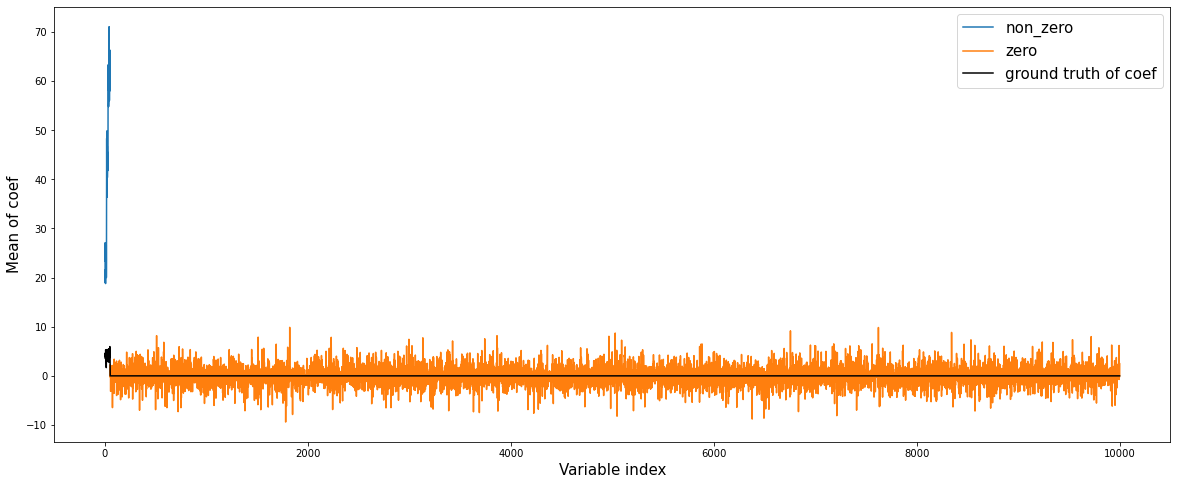

In [17]:
coef_mean = HiLasso2.coef_.mean(axis = 0)

plt.figure(figsize = (20,8))
plt.plot(range(50), coef_mean[:50], label = 'non_zero')
plt.plot(range(50,10000), coef_mean[50:], label = 'zero')
plt.plot(beta, label = 'ground truth of coef', c = 'black')
plt.legend(fontsize = 15)
plt.xlabel('Variable index', size = 15)
plt.ylabel('Mean of coef', size = 15)
plt.show()


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1158.97it/s]


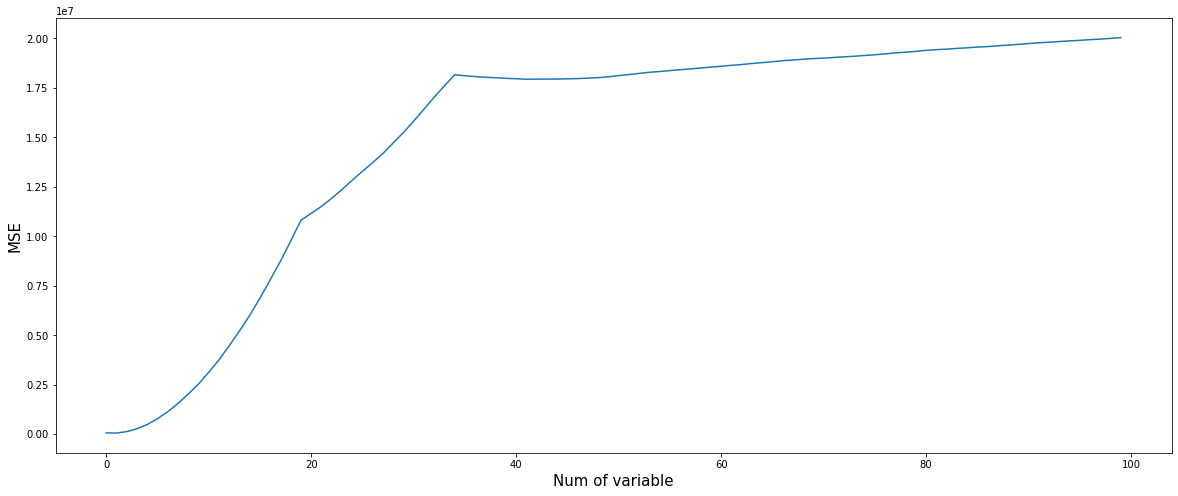

In [18]:
temp = np.sort(abs(coef_mean))[::-1]
temp2 = abs(coef_mean)
rank = [np.where(temp == temp2[i])[0][0] for i in range(len(coef_mean))]

mse = [mse(y, (X[:, np.array(rank) <= i] @ coef_mean[np.array(rank) <= i])) for i in tqdm(range(100))]

plt.figure(figsize = (20,8))
plt.plot(mse)
plt.xlabel('Num of variable', size = 15)
plt.ylabel('MSE', size = 15)
plt.show()

In [19]:
pred = np.zeros(len(rank))
pred[np.array(rank) <= mse.index(min(mse))] = 1

confusion_matrix(pred,[1]*50+[0]*9950)

array([[9950,   48],
       [   0,    2]])

In [20]:
#f1 score
f1_score(pred,[1]*50+[0]*9950)

0.07692307692307693

In [21]:
# PSTVSboot
r, p = HiLasso2.coef_.shape
pi = (HiLasso2.coef_ != 0).sum() / (r*p)
d_j = (HiLasso2.coef_ != 0).sum(axis = 0)
p_v = binom.sf(d_j - 1, n=r, p=pi)
pred = np.zeros(len(rank))
pred[p_v < 0.05] = 1

confusion_matrix(pred,[1]*50+[0]*9950)

array([[8844,    0],
       [1106,   50]])

In [22]:
#f1 score
f1_score(pred,[1]*50+[0]*9950)

0.08291873963515753

In [6]:
#Empirical distribution
alpha = 2.5
pred = (~(np.percentile(HiLasso2.coef_, alpha, axis = 0) <= 0) &
        (np.percentile(HiLasso2.coef_, 100-alpha, axis = 0) >= 0)).astype(int)

confusion_matrix(pred,[1]*50+[0]*9950)

array([[9948,    1],
       [   2,   49]])

In [7]:
f1_score(pred,[1]*50+[0]*9950)

0.9702970297029702

In [25]:
## Save pickle
with open("Hilasso2_coef.pickle","wb") as fw:
    pickle.dump(HiLasso2.coef_, fw)